# 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

## 7.2.1 콜백을 사용하여 모델의 훈련 과정 제어하기

### keras의 callback
- callback은 모델의 `fit()`이 호출될 때 전달되는 객체를 뜻함
- 모델의 상태와 성능에 대한 모든 정보에 접근하고 훈련 중지, 모델 저장, 가중치 적재 또는 모델 상태 변경 등을 처리할 수 있음


- callback을 사용하는 몇가지 사례
    - 모델 체크포인트 저장 : 훈련 중에 모델의 가중치를 저장
    - 조기 종료(early stopping) : 특정 모니터링 지표가 더이상 향상되지 않을 때 훈련을 중지(가장 좋은 결과를 얻은 모델을 저장)
    - 훈련 중 하이퍼파라미터 값을 동적으로 조정 : 훈련 중 optimizer의 learning rate를 조정
    - 훈련과 검증 지표를 log에 기록하거나 모델의 가중치가 업데이트 될 때마다 시각화 : 케라스의 진행 표시줄(progress bar)이 하나의 콜백
  
    
- 여러 내장 콜백들은 `keras.callbacks` 모듈에 있음


- 참고) 자동으로 추가되는 콜백들
    - `fit()`메서드가 반환하는 history 객체를 위한 `History` callback
    - 측정 지표의 평균을 계산하는 `BaseLogger` callback
    - `fit()` 메서드에 `verbose=0`을 지정하지 않았다면 진행 표시줄을 위한 `ProgbarLogger` callback
    

### ModelCheckpoint와 EarlyStopping 콜백

- `EarlyStopping` callback을 사용하면 epoch 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지할 수 있음
- 일반적으로 훈련 중 모델을 저장하는 `ModelCheckpoint` callback과 같이 사용됨

In [ ]:
# ModelCheckpoint와 EarlyStopping의 사용 예

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# 여러 callback들을 리스트로 전달할 수 있음
callbacks_list = [
    # 검증 정확도(val_acc)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(
        monitor='val_acc', # 기본값은 monitor='val_loss'
        patience=10
    ),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              # 정확도를 모니터링 하므로 반드시 모델 지표에 포함되어야 함
              metrics=['acc'])


model.fit(x_train, y_train,
          epochs=100,
          batch_size=32,
          callbacks=callbacks_list,
          # 검증 정확도와 검증 손실을 모니터링하므로 검증 데이터가 반드시 전달되어야 함
          validation_data=(x_val, y_val))

### ReduceLROnPlateau 콜백

- ReduceLROnPlateau 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 조절할 수 있음
    - 훈련 중 local minimum에서 벗어나는데 도움이 됨

In [ ]:
# ReduceLROnPlateau 콜백 사용 예

from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks_list = [
    ReduceLROnPlateau(
        # 검증 손실이 10 epoch동안 좋아지지 않으면 학습률에 0.1을 곱함(학습률을 1/10으로)
        monitor='val_loss',
        factor=0.1,
        patience=10
    )
]

model.fit(x_train, y_train,
          epochs=100,
          batch_size=32,
          callbacks=callbacks_list,
          # 검증 손실을 모니터링하므로 검증 데이터가 반드시 전달되어야 함
          validation_data=(x_val, y_val))

### 자신만의 콜백 만들기

- 내장 콜백에서 제공하지 않는 다른 기능이 필요하면 직접 정의해서 사용할 수 있음


- `keras.callbacks.Callback` 클래스를 상속받아 아래의 약속된 메서드를 구현
    - `on_epoch_begin` : epoch 시작 전 호출
    - `on_epoch_end`   : epoch 끝난 후 호출
    
    - `on_batch_begin` : batch 처리 시작 전 호출
    - `on_batch_end`   : batch 처리 끝난 후 호출
    
    - `on_train_begin` : 훈련 시작 시 호출
    - `on_train_end`   : 훈련 끝날 때 호출
    

- 위 메서드들은 모두 `logs` 매개변수와 함께 호출됨
    - `logs` 매개변수에는 이전 batch, epoch에 대한 훈련 및 검증 측정값이 담겨있는 딕셔너리가 전달됨


- 콜백은 아래의 속성을 참조할 수 있음
    - `self.model` : 콜백을 호출하는 모델 객체
    - `self.validation_data` : `fit()` 메서드에 전달된 검증 데이터

In [ ]:
# 사용자 정의 콜백 예

# 매 epoch의 끝에서 검증 세트의 첫번째 샘플을 입력으로
# 모든 층의 활성화 출력을 계산 후 넘파이 배열로 저장하는 콜백의 예

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

import numpy as np

class ActivationLogger(Callback):
    
    # set_model()은 호출하는 모델의 정보를 전달하기 위해 훈련 전에 호출됨
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        # 
        self.activations_model = Model(model.input, layer_outputs)
        
    
    def on_epoch_end(self, epoch, logs=None):
        if self.activation_data is None:
            raise RuntimeError('Requires validation data')
            
        # 검증 데이터의 첫번째 샘플을 가져옴
        # [0:1]은 데이터, 레이블 둘 모두 가져온다는 의미
        # 첫번째 원소 : 입력 데이터, 두번째 원소 : 레이블
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
#         f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
#         np.savez(f, activations)
#         f.close()
        with open('activations_at_epoch_' + str(epoch) + '.npz', 'wb') as f:
            np.savez(f, activations)

## 7.2.2 텐서보드 소개 : 텐서플로의 시각화 프레임워크

### 모델을 발전시켜나가는 과정

1. 모델의 실험 과정에서 많은 피드백(정보)을 받음
    - 텐서 보드의 역할


2. 피드백을 토대로 새로운 아이디어를 얻어서 검증할 실험을 계획
    - 케라스의 역할


3. 계획한 실험을 통해 결과를 얻음
    - 고속의 GPU(하드웨어)의 역할
    
<img src="./images/progress.png" alt="progress" align="left"/>

### 텐서보드

- 텐서보드는 텐서플로와 함께 제공되는 브라우저 기반 시각화 도구이며 훈련 모델의 내부에서 일어나는 모든 것을 시각적으로 모니터링할 수 있도록 도와줌


- 텐서보드의 여러가지 기능
    - 훈련 중 측정 지표의 모니터링
    - 모델 구조의 시각화
    - 활성화 출력과 gradient의 histogram
    - 3D로 Embedding을 표현

### 텐서보드의 사용 예제 : IMDB 감성분석 문제

In [1]:
# IMDB 데이터 로드

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import layers
from tensorflow.keras import optimizers

# 빈도수 높은 2000개 단어만 사용
max_features = 2000
# 각 문장은 500단어로 제한
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = tf.keras.Sequential()

model.add(layers.Embedding(max_features, 128,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizers=optimizers.RMSprop(lr=0.1),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

In [2]:
# 로그파일 저장할 디렉토리 생성

import os

log_dir = os.path.join(os.getcwd(), 'my_log_dir')

if not os.path.isdir(log_dir) :
    os.mkdir(log_dir)

In [3]:
from tensorflow.keras import callbacks

callbacks_list = [
    callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1, # 1 epoch마다 활성화 출력의 히스토그램 기록
        embeddings_freq=1 # 1 epoch마다 임베딩 데이터 기록
    )
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks_list)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 6s 323us/sample - loss: 0.6080 - acc: 0.6775 - val_loss: 0.4391 - val_acc: 0.8382
Epoch 2/20
20000/20000 [==============================] - 5s 233us/sample - loss: 0.4480 - acc: 0.8544 - val_loss: 0.4628 - val_acc: 0.8612
Epoch 3/20
20000/20000 [==============================] - 5s 253us/sample - loss: 0.3726 - acc: 0.8862 - val_loss: 0.5374 - val_acc: 0.8494
Epoch 4/20
20000/20000 [==============================] - 5s 239us/sample - loss: 0.3647 - acc: 0.9015 - val_loss: 0.5576 - val_acc: 0.8656
Epoch 5/20
20000/20000 [==============================] - 5s 249us/sample - loss: 0.3046 - acc: 0.9250 - val_loss: 0.5399 - val_acc: 0.8690
Epoch 6/20
20000/20000 [==============================] - 5s 259us/sample - loss: 0.2613 - acc: 0.9398 - val_loss: 0.9808 - val_acc: 0.8236
Epoch 7/20
20000/20000 [==============================] - 5s 249us/sample - loss: 0.2346 - acc: 0.9532 - val_lo

### 텐서 보드 결과 확인

#### 텐서 보드 서버 실행 및 브라우저를 통한 접속
- 텐서보드 서버 실행
    - `$ tensorboard --logdir=<log dir path>`

- 브라우저 접속
    - http://localhost:6006/
    
    
#### 측정 지표 모니터링
- SCALARS 탭에서 볼 수 있음


![scalars](./images/tensorboard_scalars.png)

#### 활성화 출력 히스토그램
- HISTOGRAMS 탭에서 볼 수 있음


![histograms](./images/tensorboard_histograms.png)

#### 3D 단어 임베딩 시각화
- PROJECTOR 탭에서 볼 수 있음

![projector](./images/tensorboard_projector.png)

#### 그래프 구조 시각화
- GRAPHS 탭에서 볼 수 있음

![graphs](./images/tensorboard_graphs.png)

### 케라스의 `keras.utils.plot_model` 유틸리티

- 그래프 구조를 텐서보드보다 간단하고 깔끔하게 그려주는 기능을 제공
- 파이썬의 pydot, pydot-ng, graphviz 라이브러리가 필요

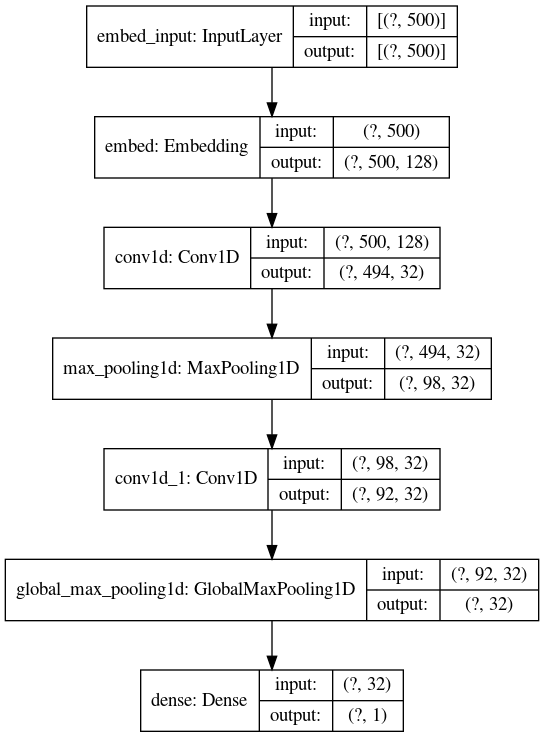

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, to_file="./images/model.png")